# Implement a Simple VAE on MNIST

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## 1. Update Autoencoder to VAE

In [40]:
class VAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # encoder
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 28*28)

    def encode(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = torch.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        
        return x.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## 3. VAE Loss Function

In [41]:
import torch.nn.functional as F

In [42]:
def vae_loss(recon_x, x, mu, logvar):
    recon_x = recon_x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kld) / x.size(0)


In [43]:
def train_one_epoch(model, loss_func, optimizer, data_loader):
    model.train()
    running_loss = 0.0

    for x, _ in data_loader:

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)

        loss = loss_func(x_recon, x, mu, logvar) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    avg_loss = running_loss / len(data_loader.dataset)
    print(f"Train loss: {avg_loss:.4f}")
    return avg_loss

In [44]:
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [56]:
model = VAutoencoder()
loss_func = vae_loss
optim = torch.optim.SGD(params = model.parameters(), lr = 0.001)

In [57]:
epochs = 80

for i in range(epochs):
    print(f"Epoch {i}....")
    train_one_epoch(model, loss_func, optim, train_loader)

Epoch 0....
Train loss: 267.3594
Epoch 1....
Train loss: 214.2134
Epoch 2....
Train loss: 208.1824
Epoch 3....
Train loss: 197.8653
Epoch 4....
Train loss: 188.1664
Epoch 5....
Train loss: 180.4417
Epoch 6....
Train loss: 175.1286
Epoch 7....
Train loss: 171.0193
Epoch 8....
Train loss: 167.9745
Epoch 9....
Train loss: 164.9739
Epoch 10....
Train loss: 162.3518
Epoch 11....
Train loss: 160.1270
Epoch 12....
Train loss: 158.1067
Epoch 13....
Train loss: 156.2729
Epoch 14....
Train loss: 154.6480
Epoch 15....
Train loss: 153.0952
Epoch 16....
Train loss: 151.6299
Epoch 17....
Train loss: 150.2118
Epoch 18....
Train loss: 148.9258
Epoch 19....
Train loss: 147.7342
Epoch 20....
Train loss: 146.4668
Epoch 21....
Train loss: 145.3955
Epoch 22....
Train loss: 144.3125
Epoch 23....
Train loss: 143.3001
Epoch 24....
Train loss: 142.3304
Epoch 25....
Train loss: 141.4534
Epoch 26....
Train loss: 140.5503
Epoch 27....
Train loss: 139.7644
Epoch 28....
Train loss: 139.0853
Epoch 29....
Train loss:

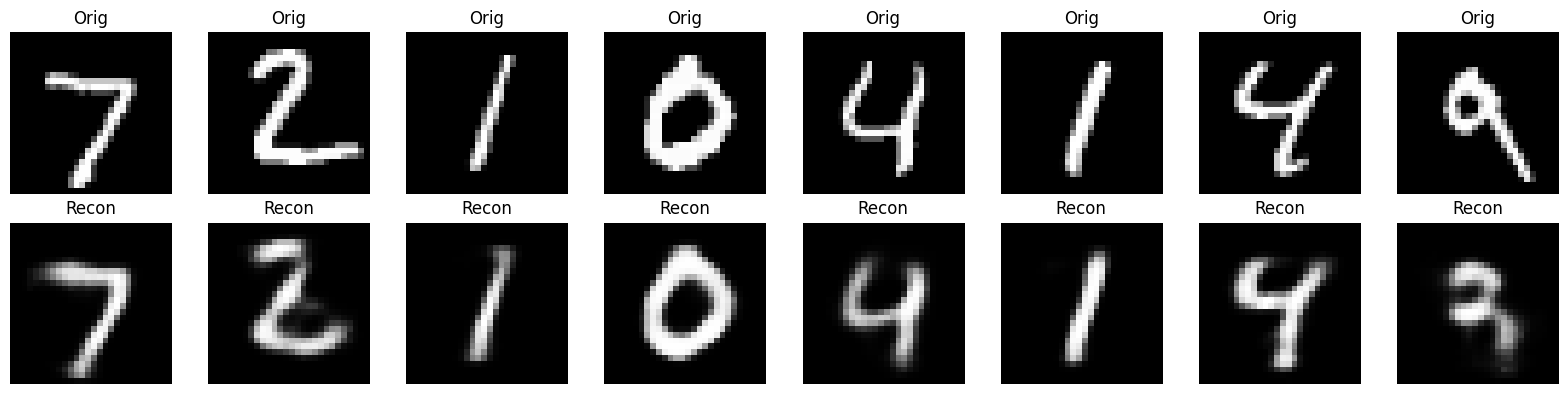

In [58]:
import torch
import matplotlib.pyplot as plt

model.eval()

# how many examples to show
n = 8

# get one batch
x_batch, y_batch = next(iter(test_loader))

device = next(model.parameters()).device
x_batch = x_batch.to(device)

with torch.no_grad():
    x_recon = model(x_batch)
n = min(n, x_batch.size(0))

fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))

for i in range(n):
    orig = x_batch[i].cpu()
    recon = x_recon[0][i].cpu()

    # handle shapes: [1,H,W] (grayscale) or [3,H,W] (RGB)
    def prep(img):
        if img.dim() == 3:
            if img.size(0) == 1:
                img = img.squeeze(0)          # -> [H,W]
            elif img.size(0) == 3:
                img = img.permute(1, 2, 0)    # -> [H,W,3]
        return img

    orig_img = prep(orig)
    recon_img = prep(recon)

    # top row: originals
    axes[0, i].imshow(orig_img, cmap="gray" if orig_img.ndim == 2 else None)
    axes[0, i].set_title("Orig")
    axes[0, i].axis("off")

    # bottom row: reconstructions
    axes[1, i].imshow(recon_img, cmap="gray" if recon_img.ndim == 2 else None)
    axes[1, i].set_title("Recon")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()
